##### !pip install --upgrade pip
!pip install -q efficientnet

In [2]:
import numpy as np 
import pandas as pd

import time
import random
import os
import cv2
import json
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelBinarizer
from collections import Counter
import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet101, ResNet101V2, VGG16, VGG19, ResNet50, ResNet50V2, ResNet152, ResNet152V2, InceptionResNetV2, Xception, InceptionV3
from efficientnet.tfkeras import EfficientNetB7, EfficientNetL2

from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
print(tf.__version__)

2.4.1


In [4]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [5]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


Number of images in train set :  2993
Number of images in test set :  643
Number of images in val set :  642


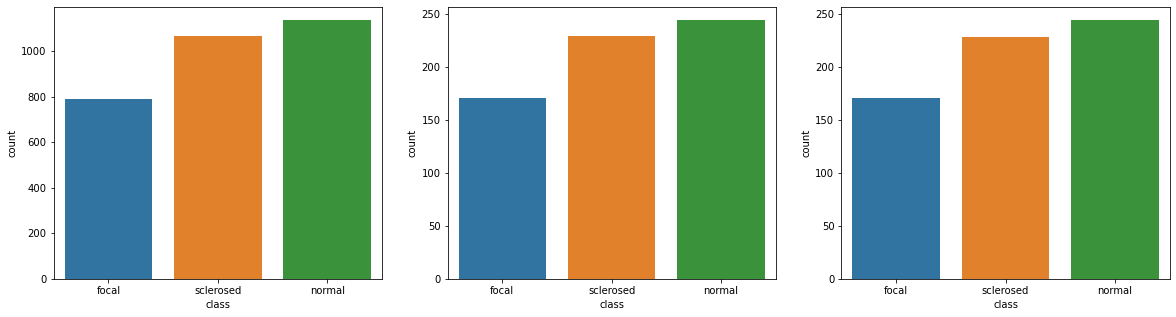

In [6]:
root_path = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/'
train_pred_test_folders = os.listdir(root_path)

train_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/train/' #one more seg_train folder within
test_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/test/'
val_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/val/'
quantity_tr = {} 
quantity_te = {}
quantity_va = {}
for folder in os.listdir(train_folders):
    quantity_tr[folder] = len(os.listdir(train_folders+folder))

for folder in os.listdir(test_folders):
    quantity_te[folder] = len(os.listdir(test_folders+folder))

for folder in os.listdir(val_folders):
    quantity_va[folder] = len(os.listdir(val_folders+folder))

quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])
quantity_val = pd.DataFrame(list(quantity_va.items()), index=range(0,len(quantity_va)), columns=['class','count'])

figure, ax = plt.subplots(1,3,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])
sns.barplot(x='class',y='count',data=quantity_val,ax=ax[2])
#sns.barplot(x='class',y='count',data=quantity_new_data,ax=ax[3])

print("Number of images in train set : ", sum(quantity_tr.values()))
print("Number of images in test set : ",sum(quantity_te.values()))
#number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
print("Number of images in val set : ",sum(quantity_va.values()))
#print("Number of images in new dataset : ",sum(quantity_ne.values()))

plt.show()

In [7]:
BUFFER_SIZE = len(train_folders)
BATCH_SIZE = 64
IMG_SIZE = 150
EPOCH = 5

In [8]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [9]:
train_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_generator = train_datagen.flow_from_directory(train_folders,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=BUFFER_SIZE,
                                                    class_mode='categorical',
                                                    target_size=(IMG_SIZE, IMG_SIZE))

validation_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(val_folders, 
                                                              shuffle=BUFFER_SIZE, 
                                                              batch_size=BATCH_SIZE, 
                                                              class_mode='categorical', 
                                                              target_size=(IMG_SIZE, IMG_SIZE))

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.


In [10]:
test_datagen = ImageDataGenerator( rescale = 1.0/IMG_SIZE)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
test_generator = test_datagen.flow_from_directory(test_folders,
                                                   batch_size=BATCH_SIZE,
                                                   shuffle=BUFFER_SIZE,
                                                   class_mode='categorical',
                                                   target_size=(IMG_SIZE, IMG_SIZE))

Found 643 images belonging to 3 classes.


In [11]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'focal': 0, 'normal': 1, 'sclerosed': 2}
{0: 'focal', 1: 'normal', 2: 'sclerosed'}


In [12]:
classes = validation_generator.class_indices

class_json = json.dumps(classes, sort_keys=True)
print(class_json)

with open('classes.json', 'w') as file:
  json.dump(classes, file)

{"focal": 0, "normal": 1, "sclerosed": 2}


In [13]:
def show_few_images(number_of_examples, predict_using_model):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_folders)):
        image_ids = os.listdir(os.path.join(train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            path = os.path.join(train_folders,folder,image_ids[j])
            display = cv2.resize(cv2.imread(path),(IMG_SIZE,IMG_SIZE))
            display = display/IMG_SIZE
            
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(predict_using_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


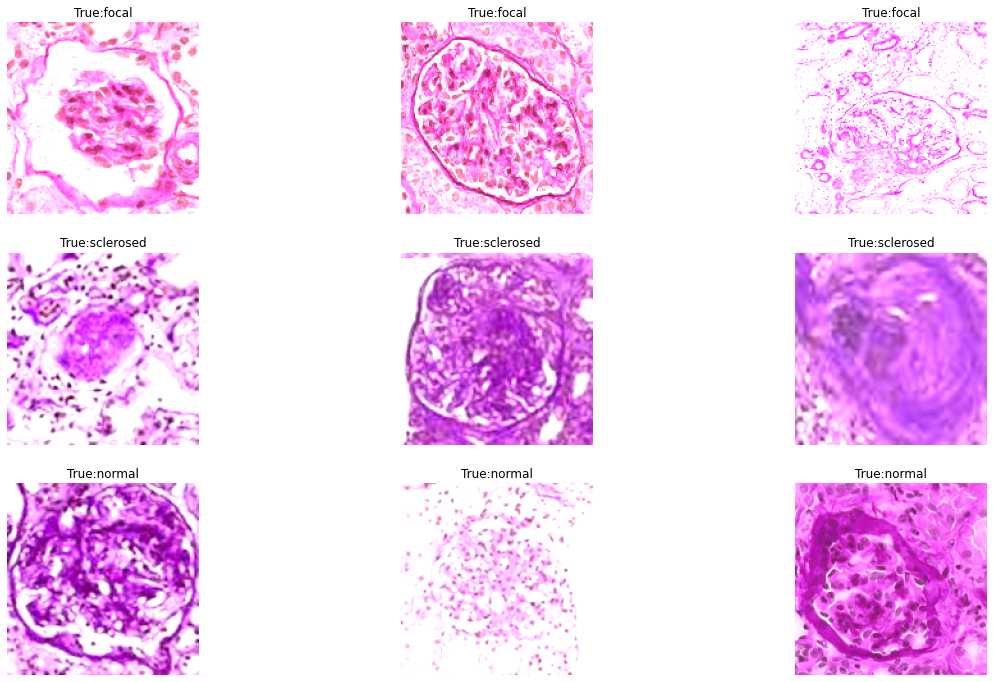

In [14]:
show_few_images(3,None)

## VGG16

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


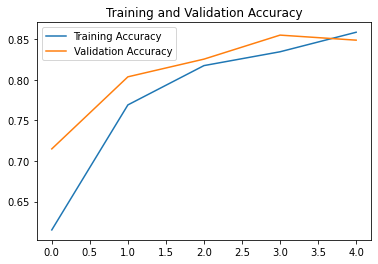

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


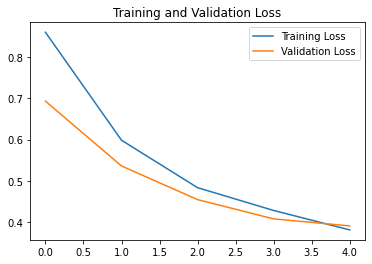

<Figure size 432x288 with 0 Axes>

In [15]:
vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
for layers in vgg16_model.layers:
            layers.trainable=False
last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(3, activation = 'softmax')(vgg_x)
vgg16_final_model = Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

# VGG16
vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

vgg16_final_model.summary()
since = time.time()
vgg16_history = vgg16_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=vgg_early_stopping,verbose=1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(vgg16_history, 'vgg16_model')

In [16]:
vgg16_final_model.evaluate(test_generator)
vgg16_best_model = vgg16_final_model
vgg16_final_model.save("/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/model/result/vgg16.h5")

11/11 [==============================] - 13s 1s/step - loss: 0.3815 - acc: 0.8429


## VGG19

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


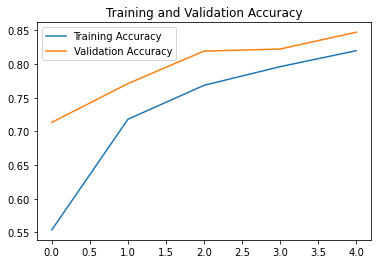

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


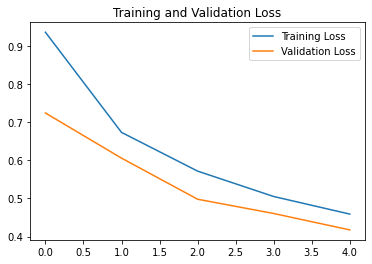

<Figure size 432x288 with 0 Axes>

In [17]:
vgg19_model = VGG19(pooling='avg', weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
for layers in vgg19_model.layers:
            layers.trainable=False
last_output = vgg19_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(3, activation = 'softmax')(vgg_x)
vgg19_final_model = Model(vgg19_model.input, vgg_x)
vgg19_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

vgg19_final_model.summary()
since = time.time()
vgg19_history = vgg19_final_model.fit(train_generator, epochs = EPOCH ,validation_data = validation_generator,callbacks=vgg_early_stopping,verbose=1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(vgg19_history, 'vgg19_model')

In [18]:
vgg19_final_model.evaluate(test_generator)
vgg19_best_model = vgg19_final_model
vgg19_final_model.save("/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/model/result/vgg19.h5")

11/11 [==============================] - 2s 168ms/step - loss: 0.4446 - acc: 0.8383


## ResNet50

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Epoch 1/5
47/47 [==============================] - 121s 2s/step - loss: 1.3392 - acc: 0.7078 - val_loss: 1.0861 - val_acc: 0.3801
Epoch 2/5
47/47 [==============================] - 11s 233ms/step - loss: 0.1376 - acc: 0.9531 - val_loss: 1.1360 - val_acc: 0.2960
Epoch 3/5
47/47 [==============================] - 11s 236ms/step - loss: 0.0362 - acc: 0.9928 - val_loss: 1.1813 - val_acc: 0.2648
Epoch 4/5
47/47 [==============================] - 11s 237ms/step - loss: 0.0113 - acc: 0.9982 - val_loss: 1.2002 - val_acc: 0.2648
Epoch 5/5
47/47 [==============================] - 11s 235ms/step - loss: 0.0057 - acc: 0.9993 - val_loss: 1.2367 - val_acc: 0.2648
Elapsed Time in 166 second
Training completed in 2m 46s


/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


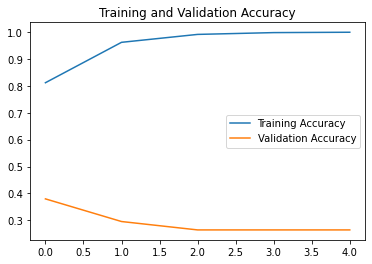

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


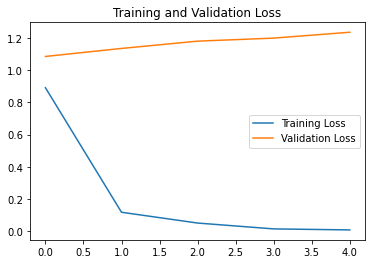

<Figure size 432x288 with 0 Axes>

In [19]:
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), classes=3)

for layers in ResNet50_model.layers:
    layers.trainable=True

opt = SGD(lr=0.01,momentum=0.7)
# resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
# resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
resnet50_x = Flatten()(ResNet50_model.output)
resnet50_x = Dense(256,activation='relu')(resnet50_x)
resnet50_x = Dense(3,activation='softmax')(resnet50_x)
resnet50_x_final_model = Model(inputs=ResNet50_model.input, outputs=resnet50_x)
resnet50_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_early_stopping,reduce_lr]

resnet50_x_final_model.summary()
since = time.time()
resnet50_history = resnet50_x_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=callbacklist,verbose=1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(resnet50_history, 'resnet50_model')

In [20]:
resnet50_x_final_model.evaluate(test_generator)
resnet50_best_model = resnet50_x_final_model
resnet50_x_final_model.save("/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/model/result/resnet50.h5")

11/11 [==============================] - 19s 2s/step - loss: 1.2392 - acc: 0.2644


## ResNet50V2

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

Epoch 1/5
47/47 [==============================] - 110s 1s/step - loss: 1.3512 - acc: 0.6874 - val_loss: 2.4141 - val_acc: 0.5062
Epoch 2/5
47/47 [==============================] - 11s 227ms/step - loss: 0.1095 - acc: 0.9644 - val_loss: 0.6027 - val_acc: 0.7928
Epoch 3/5
47/47 [==============================] - 11s 224ms/step - loss: 0.0309 - acc: 0.9905 - val_loss: 0.4864 - val_acc: 0.8754
Epoch 4/5
47/47 [==============================] - 10s 220ms/step - loss: 0.0185 - acc: 0.9939 - val_loss: 0.3033 - val_acc: 0.9097
Epoch 5/5
47/47 [==============================] - 11s 221ms/step - loss: 0.0059 - acc: 0.9988 - val_loss: 0.2381 - val_acc: 0.9330
Elapsed Time in 153 second
Training completed in 2m 33s


/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


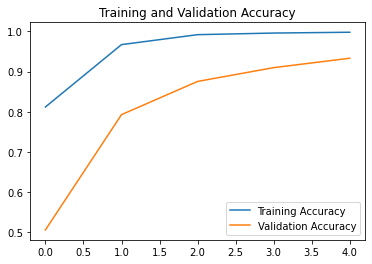

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


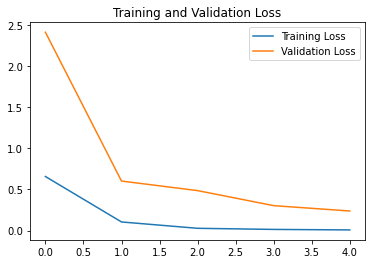

<Figure size 432x288 with 0 Axes>

In [21]:
ResNet50v2_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), classes=3)

for layers in ResNet50v2_model.layers:
    layers.trainable=True

opt = SGD(lr=0.01,momentum=0.7)
# resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
# resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
resnet50v2_x = Flatten()(ResNet50v2_model.output)
resnet50v2_x = Dense(256,activation='relu')(resnet50v2_x)
resnet50v2_x = Dense(3,activation='softmax')(resnet50v2_x)
resnet50v2_x_final_model = Model(inputs=ResNet50v2_model.input, outputs=resnet50v2_x)
resnet50v2_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_early_stopping,reduce_lr]

resnet50v2_x_final_model.summary()
since = time.time()
resnet50v2_history = resnet50v2_x_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=callbacklist,verbose=1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(resnet50v2_history, 'resnet50v2_model')

In [22]:
resnet50v2_x_final_model.evaluate(test_generator)
resnet50v2_best_model = resnet50v2_x_final_model
resnet50v2_x_final_model.save("/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/model/result/resnet50v2.h5")

11/11 [==============================] - 18s 2s/step - loss: 0.2442 - acc: 0.9347


## ResNet101

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Epoch 1/5
47/47 [==============================] - 24s 383ms/step - loss: 1.0887 - acc: 0.7598 - val_loss: 1.4897 - val_acc: 0.3645
Epoch 2/5
47/47 [==============================] - 17s 352ms/step - loss: 0.0500 - acc: 0.9831 - val_loss: 2.0187 - val_acc: 0.3551
Epoch 3/5
47/47 [==============================] - 17s 354ms/step - loss: 0.0099 - acc: 0.9970 - val_loss: 1.3007 - val_acc: 0.3738
Epoch 4/5
47/47 [==============================] - 17s 354ms/step - loss: 0.0043 - acc: 0.9985 - val_loss: 1.4511 - val_acc: 0.3801
Epoch 5/5
47/47 [==============================] - 17s 357ms/step - loss: 0.0032 - acc: 0.9999 - val_loss: 1.2026 - val_acc: 0.3754
Elapsed Time in 92 second
Training completed in 1m 32s


/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


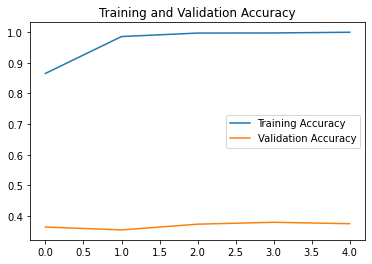

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


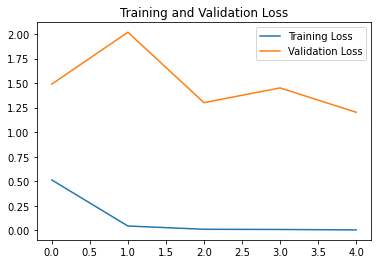

<Figure size 432x288 with 0 Axes>

In [23]:
ResNet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), classes=3)

for layers in ResNet101_model.layers:
    layers.trainable=True

opt = SGD(lr=0.01,momentum=0.7)
# resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
# resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
resnet101_x = Flatten()(ResNet101_model.output)
resnet101_x = Dense(256,activation='relu')(resnet101_x)
resnet101_x = Dense(3,activation='softmax')(resnet101_x)
resnet101_x_final_model = Model(inputs=ResNet101_model.input, outputs=resnet101_x)
resnet101_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_early_stopping,reduce_lr]

resnet101_x_final_model.summary()
since = time.time()
resnet101_history = resnet101_x_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=callbacklist,verbose=1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(resnet101_history, 'resnet101_model')

In [24]:
resnet101_x_final_model.evaluate(test_generator)
resnet101_best_model = resnet101_x_final_model
resnet101_x_final_model.save("/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/model/result/resnet101.h5")

11/11 [==============================] - 2s 166ms/step - loss: 1.2004 - acc: 0.3826


## ResNet101V2

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

Epoch 1/5
47/47 [==============================] - 22s 351ms/step - loss: 1.5470 - acc: 0.5305 - val_loss: 1.4146 - val_acc: 0.7819
Epoch 2/5
47/47 [==============================] - 15s 325ms/step - loss: 0.3942 - acc: 0.8075 - val_loss: 1.2557 - val_acc: 0.7508
Epoch 3/5
47/47 [==============================] - 15s 325ms/step - loss: 0.2561 - acc: 0.8935 - val_loss: 0.9059 - val_acc: 0.8224
Epoch 4/5
47/47 [==============================] - 15s 325ms/step - loss: 0.1437 - acc: 0.9414 - val_loss: 2.2008 - val_acc: 0.6184
Epoch 5/5
47/47 [==============================] - 15s 326ms/step - loss: 0.0790 - acc: 0.9764 - val_loss: 0.4457 - val_acc: 0.8769
Elapsed Time in 84 second
Training completed in 1m 24s


/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


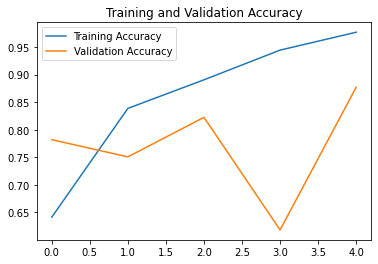

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


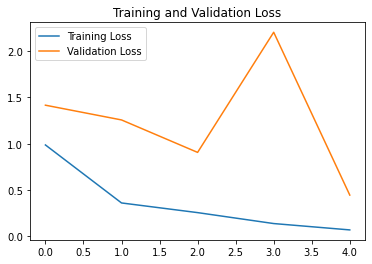

<Figure size 432x288 with 0 Axes>

In [25]:
ResNet101v2_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), classes=3)

for layers in ResNet101v2_model.layers:
    layers.trainable=True

opt = SGD(lr=0.01,momentum=0.7)
# resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
# resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
resnet101v2_x = Flatten()(ResNet101v2_model.output)
resnet101v2_x = Dense(256,activation='relu')(resnet101v2_x)
resnet101v2_x = Dense(3,activation='softmax')(resnet101v2_x)
resnet101v2_x_final_model = Model(inputs=ResNet101v2_model.input, outputs=resnet101v2_x)
resnet101v2_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

resnet101v2_x_final_model.summary()
since = time.time()
resnet101v2_history = resnet101v2_x_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=callbacklist,verbose=1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(resnet101v2_history, 'resnet101v2_model')

In [26]:
resnet101v2_x_final_model.evaluate(test_generator)
resnet101v2_best_model = resnet101v2_x_final_model
resnet101v2_x_final_model.save("/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/model/result/resnet101v2.h5")

11/11 [==============================] - 2s 169ms/step - loss: 0.5982 - acc: 0.8600


## ResNet152

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Epoch 1/5
47/47 [==============================] - 34s 527ms/step - loss: 1.3551 - acc: 0.7150 - val_loss: 1.2506 - val_acc: 0.3551
Epoch 2/5
47/47 [==============================] - 23s 484ms/step - loss: 0.0496 - acc: 0.9870 - val_loss: 1.4150 - val_acc: 0.3551
Epoch 3/5
47/47 [==============================] - 23s 488ms/step - loss: 0.0087 - acc: 0.9990 - val_loss: 1.1182 - val_acc: 0.3707
Epoch 4/5
47/47 [==============================] - 23s 484ms/step - loss: 0.0029 - acc: 0.9991 - val_loss: 1.2610 - val_acc: 0.4159
Epoch 5/5
47/47 [==============================] - 23s 484ms/step - loss: 0.0046 - acc: 0.9994 - val_loss: 1.3860 - val_acc: 0.2523
Elapsed Time in 126 second
Training completed in 2m 6s


/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


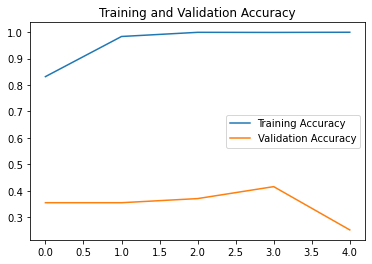

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


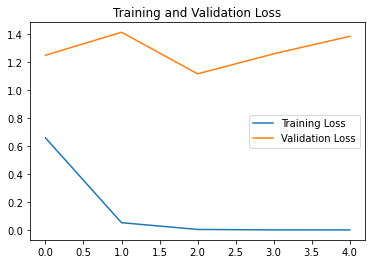

<Figure size 432x288 with 0 Axes>

In [27]:
ResNet152_model = ResNet152(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), classes=3)

for layers in ResNet152_model.layers:
    layers.trainable=True

opt = SGD(lr=0.01,momentum=0.7)
resnet152_x = Flatten()(ResNet152_model.output)
resnet152_x = Dense(256,activation='relu')(resnet152_x)
resnet152_x = Dense(3,activation='softmax')(resnet152_x)
resnet152_x_final_model = Model(inputs=ResNet152_model.input, outputs=resnet152_x)
resnet152_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

resnet152_x_final_model.summary()
since = time.time()
resnet152_history = resnet152_x_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=callbacklist,verbose=1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(resnet152_history, 'resnet152_model')

In [28]:
resnet152_x_final_model.evaluate(test_generator)
resnet152_best_model = resnet152_x_final_model
resnet152_x_final_model.save("/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/model/result/resnet152.h5")

11/11 [==============================] - 2s 159ms/step - loss: 1.3856 - acc: 0.2582


## ResNet152V2

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

__________________________________________________________________________________________________
post_relu (Activation)          (None, 5, 5, 2048)   0           post_bn[0][0]                    
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 51200)        0           post_relu[0][0]                  
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 256)          13107456    flatten_7[0][0]                  
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 3)            771         dense_14[0][0]                   
Total params: 71,439,875
Trainable params: 71,296,131
Non-trainable params: 143,744
__________________________________________________________________________________________________
Epoch 1/5
47/47 [========

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


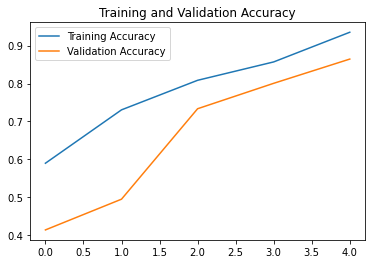

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


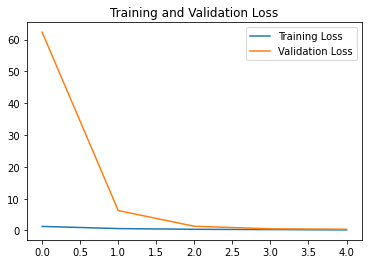

<Figure size 432x288 with 0 Axes>

In [29]:
ResNet152v2_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), classes=3)

for layers in ResNet152v2_model.layers:
    layers.trainable=True

opt = SGD(lr=0.01,momentum=0.7)
resnet152v2_x = Flatten()(ResNet152v2_model.output)
resnet152v2_x = Dense(256,activation='relu')(resnet152v2_x)
resnet152v2_x = Dense(3,activation='softmax')(resnet152v2_x)
resnet152v2_x_final_model = Model(inputs=ResNet152v2_model.input, outputs=resnet152v2_x)
resnet152v2_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

resnet152v2_x_final_model.summary()
since = time.time()
resnet152v2_history = resnet152v2_x_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=callbacklist,verbose=1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(resnet152v2_history, 'resnet152v2_model')

In [30]:
resnet152v2_x_final_model.evaluate(test_generator)
resnet152v2_best_model = resnet152v2_x_final_model
resnet152v2_x_final_model.save("/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/model/result/resnet152v2.h5")

11/11 [==============================] - 2s 175ms/step - loss: 0.4404 - acc: 0.8523


## EfficientNetB7

last layer output shape:  (None, 2560)
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 75, 75, 64)   1728        input_9[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 75, 75, 64)   256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 75, 75, 64)   0           stem_bn[0][0]                    
_____________________________________________________

block5d_add (Add)               (None, 10, 10, 224)  0           block5d_drop[0][0]               
                                                                 block5c_add[0][0]                
__________________________________________________________________________________________________
block5e_expand_conv (Conv2D)    (None, 10, 10, 1344) 301056      block5d_add[0][0]                
__________________________________________________________________________________________________
block5e_expand_bn (BatchNormali (None, 10, 10, 1344) 5376        block5e_expand_conv[0][0]        
__________________________________________________________________________________________________
block5e_expand_activation (Acti (None, 10, 10, 1344) 0           block5e_expand_bn[0][0]          
__________________________________________________________________________________________________
block5e_dwconv (DepthwiseConv2D (None, 10, 10, 1344) 33600       block5e_expand_activation[0][0]  
__________

Epoch 1/5
47/47 [==============================] - 169s 2s/step - loss: 1.0304 - acc: 0.5435 - val_loss: 0.5478 - val_acc: 0.7741
Epoch 2/5
47/47 [==============================] - 13s 279ms/step - loss: 0.6458 - acc: 0.7250 - val_loss: 0.4400 - val_acc: 0.8333
Epoch 3/5
47/47 [==============================] - 13s 280ms/step - loss: 0.5663 - acc: 0.7540 - val_loss: 0.4529 - val_acc: 0.8037

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/5
47/47 [==============================] - 13s 279ms/step - loss: 0.5399 - acc: 0.7679 - val_loss: 0.3734 - val_acc: 0.8271
Epoch 5/5
47/47 [==============================] - 13s 280ms/step - loss: 0.4998 - acc: 0.7843 - val_loss: 0.3711 - val_acc: 0.8427
Elapsed Time in 223 second
Training completed in 3m 43s


/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


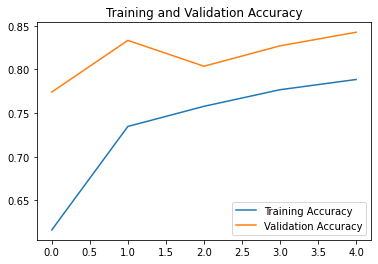

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


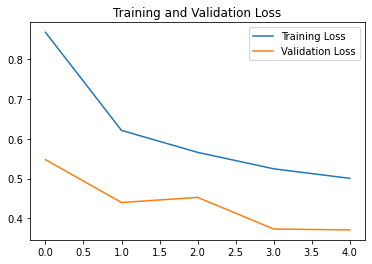

<Figure size 432x288 with 0 Axes>

In [31]:
effb7_model = EfficientNetB7(pooling='avg', 
                    weights='imagenet', 
                    include_top=False, 
                    input_shape=(150,150,3))
for layers in effb7_model.layers:
            layers.trainable=False

last_layer = effb7_model.get_layer('avg_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
effb7_x = Flatten()(last_output)
effb7_x = Dense(1024, activation = 'relu')(effb7_x)
effb7_x = Dropout(0.2)(effb7_x)
effb7_x = Dense(3, activation = 'softmax')(effb7_x)
effb7_final_model = Model(effb7_model.input, effb7_x)
effb7_final_model.compile(loss = 'categorical_crossentropy',
                          optimizer= 'adam', 
                          metrics=['acc'])

# EFFB7
effb7_final_model.summary()

reduce_lr = ReduceLROnPlateau(factor=0.5, patience=1, verbose=1, mode='min', epsilon=0.0001, min_lr=0)
es = EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='min', restore_best_weights=True)
callbacks_list = [reduce_lr, es]

since = time.time()
effb7_history = effb7_final_model.fit(train_generator,
                                      epochs = EPOCH,
                                      validation_data = validation_generator,
                                      callbacks = callbacks_list,
                                      verbose = 1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
do_history_stuff(effb7_history, 'effb7_model')

In [32]:
effb7_final_model.evaluate(test_generator)
effb7_best_model = effb7_final_model
effb7_final_model.save("/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/model/result/efficientnetb7.h5")

11/11 [==============================] - 54s 5s/step - loss: 0.3984 - acc: 0.8212


## EfficientNetL2

last layer output shape:  (None, 5504)
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 75, 75, 136)  3672        input_10[0][0]                   
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 75, 75, 136)  544         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 75, 75, 136)  0           stem_bn[0][0]                    
_____________________________________________________

__________________________________________________________________________________________________
block3i_project_conv (Conv2D)   (None, 19, 19, 176)  185856      block3i_se_excite[0][0]          
__________________________________________________________________________________________________
block3i_project_bn (BatchNormal (None, 19, 19, 176)  704         block3i_project_conv[0][0]       
__________________________________________________________________________________________________
block3i_add (Add)               (None, 19, 19, 176)  0           block3i_project_bn[0][0]         
                                                                 block3h_add[0][0]                
__________________________________________________________________________________________________
block3j_expand_conv (Conv2D)    (None, 19, 19, 1056) 185856      block3i_add[0][0]                
__________________________________________________________________________________________________
block3j_ex

__________________________________________________________________________________________________
block6a_se_squeeze (GlobalAvera (None, 2880)         0           block6a_activation[0][0]         
__________________________________________________________________________________________________
block6a_se_reshape (Reshape)    (None, 1, 1, 2880)   0           block6a_se_squeeze[0][0]         
__________________________________________________________________________________________________
block6a_se_reduce (Conv2D)      (None, 1, 1, 120)    345720      block6a_se_reshape[0][0]         
__________________________________________________________________________________________________
block6a_se_expand (Conv2D)      (None, 1, 1, 2880)   348480      block6a_se_reduce[0][0]          
__________________________________________________________________________________________________
block6a_se_excite (Multiply)    (None, 5, 5, 2880)   0           block6a_activation[0][0]         
          

Total params: 481,535,191
Trainable params: 5,640,195
Non-trainable params: 475,894,996
__________________________________________________________________________________________________
Epoch 1/5
47/47 [==============================] - 222s 3s/step - loss: 24.1102 - acc: 0.3196 - val_loss: 1.0930 - val_acc: 0.2773
Epoch 2/5
47/47 [==============================] - 49s 1s/step - loss: 1.0926 - acc: 0.3734 - val_loss: 1.0824 - val_acc: 0.3801
Epoch 3/5
47/47 [==============================] - 50s 1s/step - loss: 1.0861 - acc: 0.3754 - val_loss: 1.0838 - val_acc: 0.3801

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/5
47/47 [==============================] - 50s 1s/step - loss: 1.0888 - acc: 0.3741 - val_loss: 1.0831 - val_acc: 0.3801

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 5/5
47/47 [==============================] - 50s 1s/step - loss: 1.0833 - acc: 0.4008 - val_loss: 1.0834 - val_acc: 0.3801

Epo

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


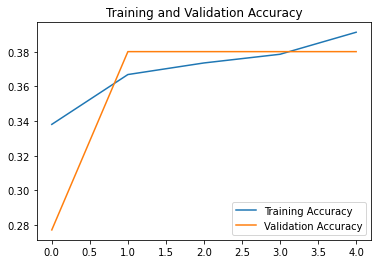

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


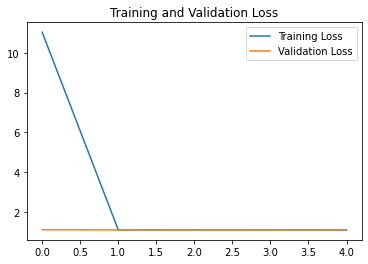

<Figure size 432x288 with 0 Axes>

In [33]:
path_weight = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/model/efficientnet/noisy-student/notop/efficientnet-l2_noisy-student_notop.h5'
effl2_model = EfficientNetL2(pooling='avg', 
                             weights=path_weight, 
                             include_top=False, 
                             input_shape=(IMG_SIZE,IMG_SIZE,3),
                             drop_connect_rate=0)
for layers in effl2_model.layers:
            layers.trainable=False

last_layer = effl2_model.get_layer('avg_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
effl2_x = Flatten()(last_output)
effl2_x = Dense(1024, activation = 'relu')(effl2_x)
effl2_x = Dropout(0.2)(effl2_x)
effl2_x = Dense(3, activation = 'softmax')(effl2_x)
effl2_final_model = Model(effl2_model.input, effl2_x)
effl2_final_model.compile(loss = 'categorical_crossentropy',
                          optimizer= 'adam', 
                          metrics=['acc'])

# EFFL2
effl2_final_model.summary()

since = time.time()
effl2_history = effl2_final_model.fit(train_generator,
                                      epochs = EPOCH,
                                      validation_data = validation_generator,
                                      callbacks = callbacks_list,
                                      verbose = 1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
do_history_stuff(effl2_history, 'effl2_model')

In [34]:
effl2_final_model.evaluate(test_generator)
effl2_best_model = effl2_final_model
effl2_final_model.save("/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/model/result/efficientnetl2.h5")

11/11 [==============================] - 68s 7s/step - loss: 1.0835 - acc: 0.3795


## InceptionV3

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

Epoch 1/5
47/47 [==============================] - 224s 3s/step - loss: 2.3158 - acc: 0.5685 - val_loss: 0.3820 - val_acc: 0.8411
Epoch 2/5
47/47 [==============================] - 11s 226ms/step - loss: 0.3636 - acc: 0.8470 - val_loss: 0.3044 - val_acc: 0.8660
Epoch 3/5
47/47 [==============================] - 11s 223ms/step - loss: 0.2649 - acc: 0.8994 - val_loss: 0.3079 - val_acc: 0.8583

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/5
47/47 [==============================] - 10s 220ms/step - loss: 0.1924 - acc: 0.9317 - val_loss: 0.2551 - val_acc: 0.9034
Epoch 5/5
47/47 [==============================] - 10s 218ms/step - loss: 0.1632 - acc: 0.9433 - val_loss: 0.2569 - val_acc: 0.9050

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Elapsed Time in 266 second
Training completed in 4m 26s


/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


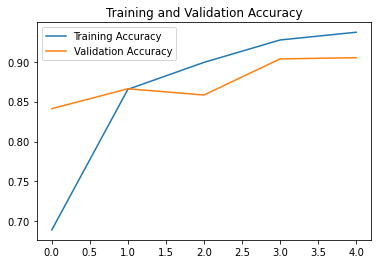

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


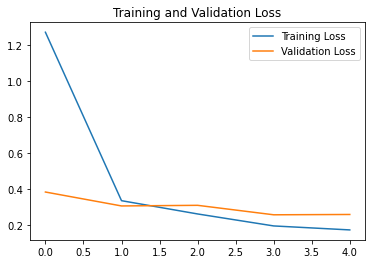

<Figure size 432x288 with 0 Axes>

In [35]:
incepv3_model = InceptionV3(pooling='avg', 
                          weights='imagenet', 
                          include_top=False, 
                          input_shape=(IMG_SIZE,IMG_SIZE,3))
for layers in incepv3_model.layers:
            layers.trainable=False

incepv3_x = incepv3_model.output
incepv3_x = Flatten()(incepv3_x)
incepv3_x = Dense(1024, activation='relu')(incepv3_x)
incepv3_x = Dropout(0.2)(incepv3_x)
incepv3_x = Dense(3, activation='softmax')(incepv3_x)
incepv3_final_model = Model(inputs=incepv3_model.input, outputs=incepv3_x)
incepv3_final_model.compile(loss = 'categorical_crossentropy',
                          optimizer= 'adam', 
                          metrics=['acc'])

incepv3_final_model.summary()

since = time.time()
incepv3_history = incepv3_final_model.fit(train_generator,
                                      epochs = EPOCH,
                                      validation_data = validation_generator,
                                      callbacks = callbacks_list,
                                      verbose = 1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
do_history_stuff(incepv3_history, 'incepv3_model')

In [36]:
incepv3_final_model.evaluate(test_generator)
incepv3_best_model = incepv3_final_model
incepv3_final_model.save("/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/model/result/inceptionv3.h5")

11/11 [==============================] - 72s 7s/step - loss: 0.2505 - acc: 0.8911


## InceptionResNetV2

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
___________________________________________________________________________________________

Total params: 55,913,699
Trainable params: 1,576,963
Non-trainable params: 54,336,736
__________________________________________________________________________________________________
Epoch 1/5
47/47 [==============================] - 139s 2s/step - loss: 2.5345 - acc: 0.5245 - val_loss: 0.4376 - val_acc: 0.8380
Epoch 2/5
47/47 [==============================] - 11s 224ms/step - loss: 0.5010 - acc: 0.7966 - val_loss: 0.3517 - val_acc: 0.8754
Epoch 3/5
47/47 [==============================] - 11s 225ms/step - loss: 0.4014 - acc: 0.8434 - val_loss: 0.3178 - val_acc: 0.8769
Epoch 4/5
47/47 [==============================] - 11s 223ms/step - loss: 0.3239 - acc: 0.8722 - val_loss: 0.3063 - val_acc: 0.8785
Epoch 5/5
47/47 [==============================] - 10s 220ms/step - loss: 0.3149 - acc: 0.8815 - val_loss: 0.2817 - val_acc: 0.8785
Elapsed Time in 182 second
Training completed in 3m 2s


/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


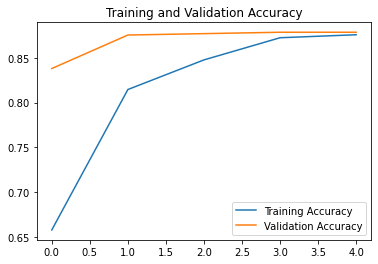

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


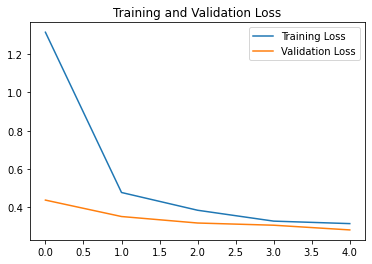

<Figure size 432x288 with 0 Axes>

In [37]:
inresv2_model = InceptionResNetV2(pooling='avg', 
                                  weights='imagenet', 
                                  include_top=False, 
                                  input_shape=(IMG_SIZE,IMG_SIZE,3))
for layers in inresv2_model.layers:
            layers.trainable=False

inresv2_x = inresv2_model.output
inresv2_x = Flatten()(inresv2_x)
inresv2_x = Dense(1024, activation='relu')(inresv2_x)
inresv2_x = Dropout(0.2)(inresv2_x)
inresv2_x = Dense(3, activation='softmax')(inresv2_x)
inresv2_final_model = Model(inputs=inresv2_model.input, outputs=inresv2_x)
inresv2_final_model.compile(loss = 'categorical_crossentropy',
                          optimizer= 'adam', 
                          metrics=['acc'])

inresv2_final_model.summary()

since = time.time()
inresv2_history = inresv2_final_model.fit(train_generator,
                                      epochs = EPOCH,
                                      validation_data = validation_generator,
                                      callbacks = callbacks_list,
                                      verbose = 1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
do_history_stuff(inresv2_history, 'inresv2_model')

In [38]:
inresv2_final_model.evaluate(test_generator)
inresv2_best_model = inresv2_final_model
inresv2_final_model.save("/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/model/result/inceptionresnetv2.h5")

11/11 [==============================] - 42s 4s/step - loss: 0.3268 - acc: 0.8787


## Xception

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_13[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

Epoch 1/5
47/47 [==============================] - 74s 1s/step - loss: 1.0096 - acc: 0.6304 - val_loss: 0.3541 - val_acc: 0.8505
Epoch 2/5
47/47 [==============================] - 11s 223ms/step - loss: 0.3117 - acc: 0.8676 - val_loss: 0.2871 - val_acc: 0.8816
Epoch 3/5
47/47 [==============================] - 10s 221ms/step - loss: 0.2327 - acc: 0.9091 - val_loss: 0.2611 - val_acc: 0.9034
Epoch 4/5
47/47 [==============================] - 10s 221ms/step - loss: 0.1651 - acc: 0.9421 - val_loss: 0.2178 - val_acc: 0.9081
Epoch 5/5
47/47 [==============================] - 11s 226ms/step - loss: 0.1450 - acc: 0.9450 - val_loss: 0.2068 - val_acc: 0.9143
Elapsed Time in 117 second
Training completed in 1m 57s


/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


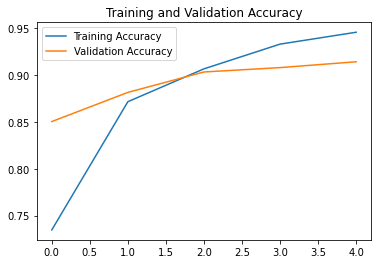

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


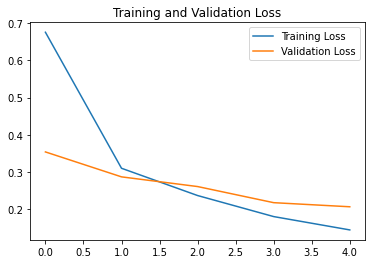

<Figure size 432x288 with 0 Axes>

In [39]:
xcep_model = Xception(pooling='avg', 
                      weights='imagenet', 
                      include_top=False, 
                      input_shape=(IMG_SIZE,IMG_SIZE,3))
for layers in xcep_model.layers:
            layers.trainable=False

xcep_x = xcep_model.output
xcep_x = Flatten()(xcep_x)
xcep_x = Dense(1024, activation='relu')(xcep_x)
xcep_x = Dropout(0.2)(xcep_x)
xcep_x = Dense(3, activation='softmax')(xcep_x)
xcep_final_model = Model(inputs=xcep_model.input, outputs=xcep_x)
xcep_final_model.compile(loss = 'categorical_crossentropy',
                          optimizer= 'adam', 
                          metrics=['acc'])

xcep_final_model.summary()

since = time.time()
xcep_history = xcep_final_model.fit(train_generator,
                                      epochs = EPOCH,
                                      validation_data = validation_generator,
                                      callbacks = callbacks_list,
                                      verbose = 1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
do_history_stuff(xcep_history, 'xcep_model')

In [40]:
xcep_final_model.evaluate(test_generator)
xcep_best_model = xcep_final_model
xcep_final_model.save("/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/model/result/xception.h5")

11/11 [==============================] - 23s 2s/step - loss: 0.2501 - acc: 0.9145
